In [98]:
import reservoirpy as rpy

rpy.verbosity(0)
rpy.set_seed(500)

#### Prepare input data

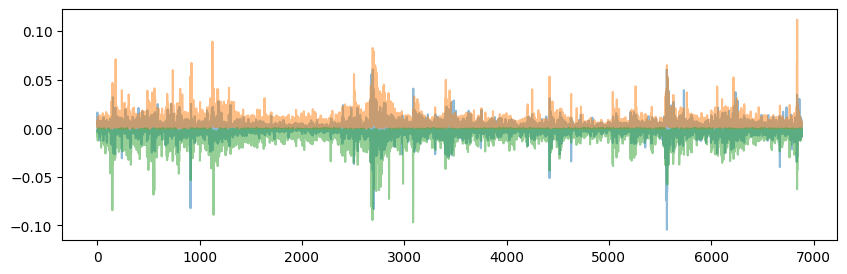

In [99]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("spy-ohlc.csv", delimiter=",", skiprows=1, usecols=(1, 2, 3, 4))

OPEN = 0
HIGH = 1
LOW = 2
CLOSE = 3

close_to_open = (data[1:, OPEN] - data[:-1, CLOSE]) / data[:-1, CLOSE]

open_to_high = ((data[:, HIGH] - data[:, OPEN]) / data[:, OPEN])[1:]

open_to_low = ((data[:, LOW] - data[:, OPEN]) / data[:, OPEN])[1:]

close = ((data[:, CLOSE] - data[:, OPEN]) / data[:, OPEN])[1:]
mask = close > 0
close[mask] = close[mask] / open_to_high[mask]
mask = close < 0
close[mask] = -(close[mask] / open_to_low[mask])

x = np.concatenate(
    (
        close_to_open.reshape(-1, 1),
        open_to_high.reshape(-1, 1),
        open_to_low.reshape(-1, 1),
        close.reshape(-1, 1),
    ),
    axis=1,
)

plt.figure(figsize=(10, 3))
plt.plot(x[:, :-1], alpha=0.5)
plt.show()

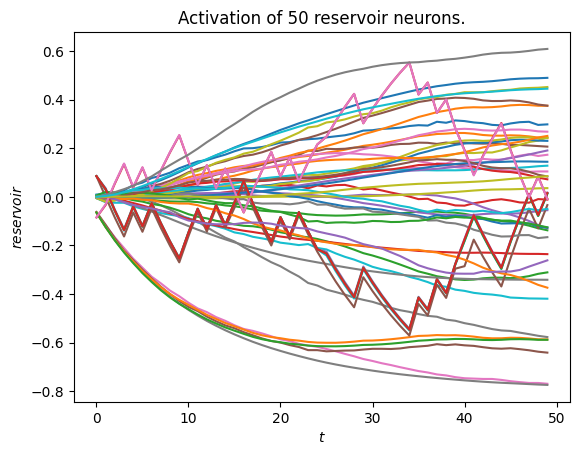

In [100]:
from reservoirpy.nodes import Reservoir

reservoir = Reservoir(
    5000,
    lr=0.085,
    sr=0.999,
    activation=rpy.activationsfunc.tanh,
    input_scaling=12,
    fb_connectivity=0.11,
    input_connectivity=0.11,
)
states = reservoir.run(x[:50])

plt.title("Activation of 50 reservoir neurons.")
plt.ylabel("$reservoir$")
plt.xlabel("$t$")
plt.plot(states[:, :50])
plt.show()

In [101]:
from reservoirpy.nodes import Ridge

readout = Ridge(ridge=1e-7)

x_train = x[:-1, :]
y_train = x[1:, :]

In [102]:
train_states = reservoir.run(x_train, reset=True)

readout = readout.fit(train_states, y_train, warmup=1000)

test_states = reservoir.run(x)
y_pred = readout.run(test_states)

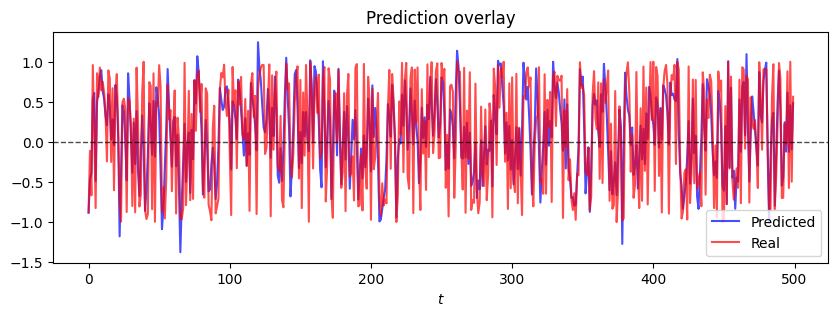

In [103]:
plt.figure(figsize=(10, 3))
plt.title("Prediction overlay")
plt.xlabel("$t$")
plt.plot(y_pred[-501:-1, CLOSE], label="Predicted", color="blue", alpha=0.7)
plt.plot(x[-500:, CLOSE], label="Real", color="red", alpha=0.7)
plt.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.7)
plt.legend()
plt.show()

mean_error=0.30067143771394955
 std_error=0.23079694616710508
false_negatives=280 of 3166
false_positives=415 of 2691


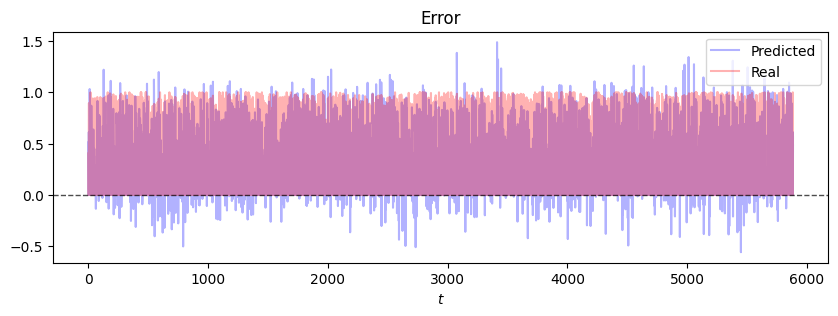

In [105]:
x_prime = x[1:, CLOSE]
y_prime = y_pred[:-1, CLOSE]
mask = x_prime[1000:] < 0
X_mask = x_prime[1000:].copy()
Y_mask = y_prime[1000:].copy()
X_mask[mask] = 0
Y_mask[mask] = 0
error = abs((Y_mask - X_mask))
print(f"mean_error={error[X_mask > 0].mean()}")
print(f" std_error={error[X_mask > 0].std()}")
print(f"false_negatives={(y_prime[1000:][x_prime[1000:] > 0] < 0).sum()} of {(x_prime[1000:] > 0).sum()}")
print(f"false_positives={(y_prime[1000:][mask] > 0).sum()} of {mask.sum()}")

plt.figure(figsize=(10, 3))
plt.title("Error")
plt.xlabel("$t$")
# plt.plot(error[-1000:], label="Error", linestyle="--", color="black", alpha=0.3)
plt.plot(Y_mask, label="Predicted", color="blue", alpha=0.3)
plt.plot(X_mask, label="Real", color="red", alpha=0.3)
plt.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.7)
plt.legend()
plt.show()
